In [1]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torch.nn as nn
from sklearn import preprocessing

In [2]:
response=requests.get('https://th.bing.com/th/id/OIP.5vYoG-ywA-DbjQ6nGMuKwQAAAA?rs=1&pid=ImgDetMain')
if response.status_code == 200:
  img = Image.open(BytesIO(response.content))

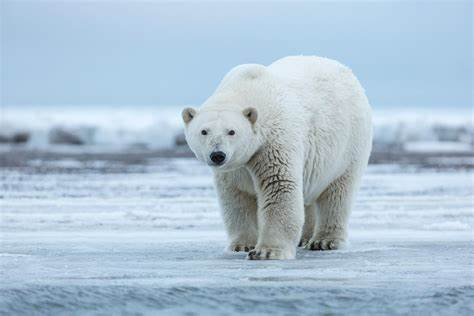

In [3]:
img


In [4]:
opencv_image = np.array(img)
opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

In [5]:
r_channel,g_channel,b_channel = cv2.split(opencv_image)


In [6]:
def factorise(A,k,device=torch.device('cpu')):

  A.to(device)

  W = torch.randn(A.shape[0],k,requires_grad=True,device=device)
  H = torch.randn(k,A.shape[1],requires_grad=True,device=device)

  optimizer = torch.optim.Adam([W,H],lr=0.01)

  losses=[]
  flat_loss = 0
  threshold = 10
  prev_loss = float('-inf')

  iteration=0
  while True:

    loss = torch.mm(W,H)-A
    mask = ~torch.isnan(loss)

    loss = loss[mask]
    loss = torch.norm(loss)

    # print(f'Iteration number: {iteration+1}  Loss: {loss.detach().cpu()}')
    losses.append(loss.detach().cpu())
    if loss.detach().cpu()>=prev_loss:
      flat_loss+=1

    else:
      flat_loss=0

    if flat_loss >=threshold:
      break

    prev_loss=loss.detach().cpu()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    iteration+=1

  return W,H,losses

In [7]:
blue_tensor = torch.tensor(b_channel,dtype=torch.float)/255
green_tensor = torch.tensor(g_channel,dtype=torch.float)/255
red_tensor = torch.tensor(r_channel,dtype=torch.float)/255

In [8]:
red_tensor=torchvision.transforms.functional.crop(red_tensor,50,150,250,250)
blue_tensor=torchvision.transforms.functional.crop(blue_tensor,50,150,250,250)
green_tensor=torchvision.transforms.functional.crop(green_tensor,50,150,250,250)

original_img = torch.stack([blue_tensor,green_tensor,red_tensor], dim=2)

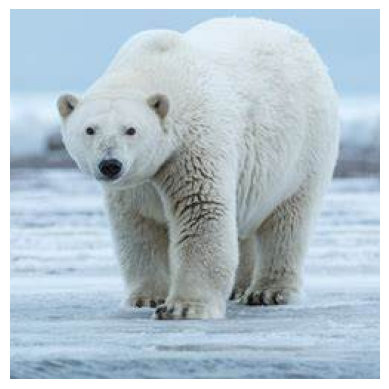

In [9]:
plt.axis('off')
plt.imshow(original_img)

In [10]:
x,y=torch.randint(0,219,(2,))
patch_red = red_tensor[y:y+50,x:x+50]
patch_green = green_tensor[y:y+50,x:x+50]
patch_blue = blue_tensor[y:y+50,x:x+50]

img_patch = torch.stack([patch_blue,patch_green,patch_red],dim=2).detach().cpu()

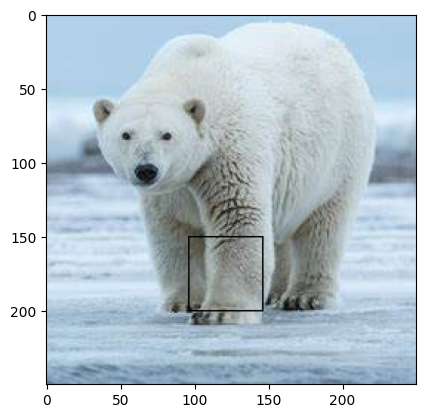

In [11]:
boxed_img=np.array(original_img.clone())
boxed_img=boxed_img

cv2.rectangle(boxed_img, (x.item(),y.item()), (x.item()+50,y.item()+50),(0), 1)

plt.imshow(boxed_img,cmap='gray')
plt.show()

In [13]:
def rmse(pred, true):
    assert pred.shape == true.shape, "Shape mismatch between predicted and true images"

    mask = ~torch.isnan(pred) & ~torch.isnan(true)

    if not torch.any(mask):
        return float('nan')

    mse = torch.mean((pred[mask] - true[mask]) ** 2)
    rmse_value = torch.sqrt(mse)

    return rmse_value.item()


def psnr(pred, true, max_pixel_value=1.0):
    assert pred.shape == true.shape, "Shape mismatch between predicted and true images"

    mask = ~torch.isnan(pred) & ~torch.isnan(true)

    if not torch.any(mask):
        return float('nan')

    mse = torch.mean((pred[mask] - true[mask]) ** 2)

    if mse == 0:
        return float('inf')

    psnr_value = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr_value.item()


RMSE for r=5: 0.039170052856206894
PSNR for r=5: 28.14091682434082

RMSE for r=10: 0.03349532186985016
PSNR for r=10: 29.500316619873047

RMSE for r=25: 0.02649463340640068
PSNR for r=25: 31.536842346191406

RMSE for r=50: 0.013751225546002388
PSNR for r=50: 37.23316955566406



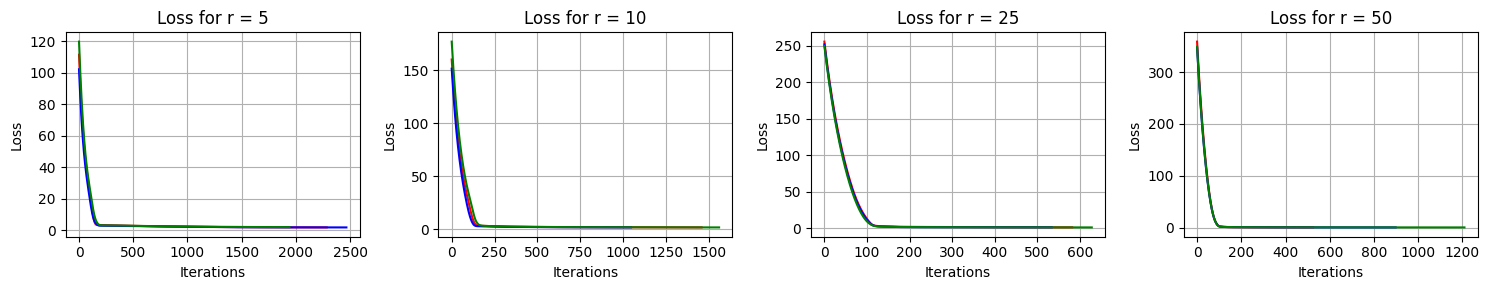

In [14]:
curr_loss=[]
plt.figure(figsize=(15,3))
for i,r in enumerate([5,10,25,50]):

  Wr,Hr,losses_r=factorise(patch_red,r)
  pred_red=torch.mm(Wr,Hr)

  Wg,Hg,losses_g=factorise(patch_green,r)
  pred_green=torch.mm(Wg,Hg)

  Wb,Hb,losses_b=factorise(patch_blue,r)
  pred_blue=torch.mm(Wb,Hb)

  pred = torch.stack([torch.mm(Wb,Hb),torch.mm(Wg,Hg),torch.mm(Wr,Hr)],dim=2).detach().cpu()

  print(f'RMSE for r={r}: {rmse(pred,img_patch)}')
  print(f'PSNR for r={r}: {psnr(pred,img_patch)}')
  print()

  plt.subplot(1,4,i+1)
  plt.grid(True)
  plt.plot(losses_r,color='red')
  plt.plot(losses_b,color = 'blue')
  plt.plot(losses_g,color = 'green')
  plt.title(f'Loss for r = {r}')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.tight_layout()

In [ ]:
# lets choose r=10 since it will save us some considerable amount of rescources

In [15]:
Wr,Hr,losses_r=factorise(patch_red,10)
pred_red=torch.mm(Wr,Hr)

Wg,Hg,losses_g=factorise(patch_green,10)
pred_green=torch.mm(Wg,Hg)

Wb,Hb,losses_b=factorise(patch_blue,10)
pred_blue=torch.mm(Wb,Hb)

pred_patch = torch.stack([torch.mm(Wb,Hb),torch.mm(Wg,Hg),torch.mm(Wr,Hr)],dim=2).detach().cpu()

In [16]:
img_with_patch = original_img.clone()
img_with_patch[y:y+50,x:x+50] = pred_patch

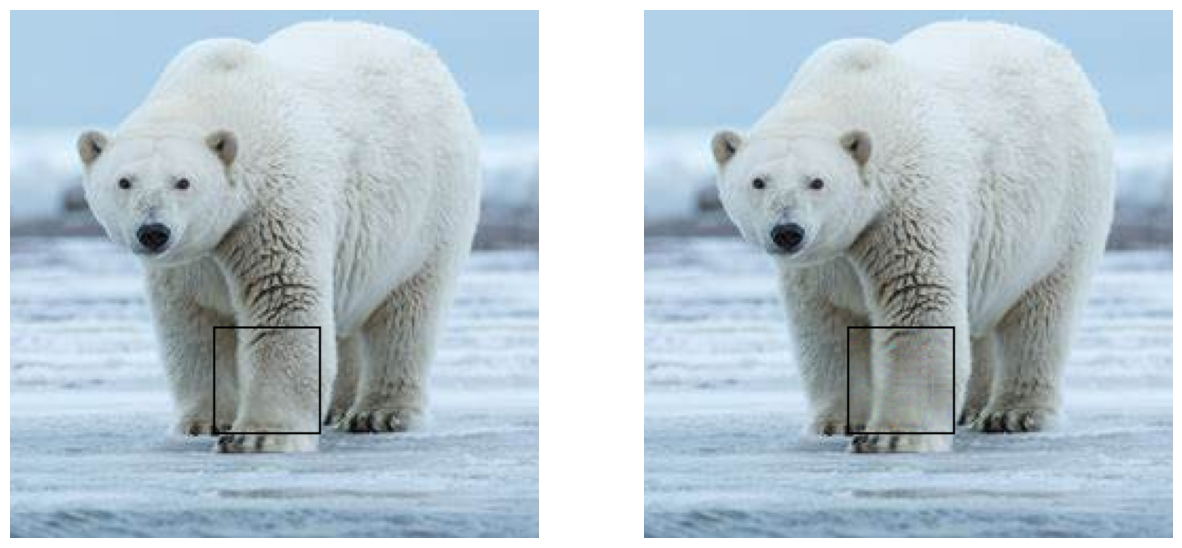

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.axis('off')
boxed_img=np.array(original_img.clone())
boxed_img=boxed_img
cv2.rectangle(boxed_img, (x.item(),y.item()), (x.item()+50,y.item()+50),(0), 1)
plt.imshow(boxed_img)

plt.subplot(1,2,2)
plt.axis('off')
boxed_img=np.array(img_with_patch.clone())
boxed_img=boxed_img
cv2.rectangle(boxed_img, (x.item(),y.item()), (x.item()+50,y.item()+50),(0), 1)
plt.imshow(boxed_img)

plt.show()